In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil
#import os

#os.makedirs("/root/.kaggle", exist_ok=True)  # Create the directory if it doesn't exist
#shutil.copy("/content/drive/MyDrive/CPRE_575_Project/Code/Facial_Expression_Recognition/kaggle (1).json", "/root/.kaggle/kaggle.json")

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

!mkdir -p /root/.kaggle/fer2013
!unzip emotion-detection-fer.zip -d /root/.kaggle/fer2013

In [ ]:
#!pip install visualkeras

In [6]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MultiHeadAttention, Dot
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input
#import visualkeras
from PIL import Image, ImageFont

import tensorflow as tf


In [ ]:
#change the train_dir and test_dir file paths, I just downloaded the archive
# I think I can just leave it in my own drive and then file path to that

#But, I think I'm gonna have to change this whole thing

Do I need to run this every time? I feel like there should be a better way to image load.

In [7]:
# Load images separately
train_faces, train_emotions = [], []
test_faces, test_emotions = [], []


train_dir = '/content/drive/MyDrive/FER2013/train'
test_dir = '/content/drive/MyDrive/FER2013/test'

# Define image size
image_size = (48, 48)

def load_images_from_directory(directory, faces_list, emotions_list):
    for emotion_folder in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion_folder)
        if os.path.isdir(emotion_path):
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)

                faces_list.append(img)
                emotions_list.append(emotion_folder)

# Load training and test sets separately
# shoot, do I need to create a list of emtions for this to work with?
load_images_from_directory(train_dir, train_faces, train_emotions)
load_images_from_directory(test_dir, test_faces, test_emotions)

# Convert to numpy arrays
train_faces, train_emotions = np.asarray(train_faces), np.asarray(train_emotions)
test_faces, test_emotions = np.asarray(test_faces), np.asarray(test_emotions)

# One-hot encode labels
train_emotions = pd.get_dummies(train_emotions).to_numpy()
test_emotions = pd.get_dummies(test_emotions).to_numpy()

# Expand dimensions for grayscale images
train_faces = np.expand_dims(train_faces, -1)
test_faces = np.expand_dims(test_faces, -1)

# Normalize pixel values [-1, 1]
train_faces = (train_faces.astype('float32') / 255.0 - 0.5) * 2.0
test_faces = (test_faces.astype('float32') / 255.0 - 0.5) * 2.0

# Split training set into train (80%) and validation (20%)
num_train_samples = int(0.8 * len(train_faces))
val_faces, val_emotions = train_faces[num_train_samples:], train_emotions[num_train_samples:]
train_faces, train_emotions = train_faces[:num_train_samples], train_emotions[:num_train_samples]

# Verify data splits
print(f"Train set: {train_faces.shape}, {train_emotions.shape}")
print(f"Validation set: {val_faces.shape}, {val_emotions.shape}")
print(f"Test set: {test_faces.shape}, {test_emotions.shape}")


Train set: (20288, 48, 48, 1), (20288, 7)
Validation set: (5072, 48, 48, 1), (5072, 7)
Test set: (7178, 48, 48, 1), (7178, 7)


I can Ignore this cell, it just runs a simple CNN model.

In [8]:
# Callbacks to monitor training
callbacks = [
     CSVLogger('emotion_training.log', append=False),
     EarlyStopping('val_loss', patience=50),
     ReduceLROnPlateau('val_loss', factor=0.1, patience=5, verbose=1),
     ModelCheckpoint('emotion_model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only=True, monitor='val_loss', verbose=1,save_freq='epoch')
 ]


In [ ]:
#I might want to add some preprocessing steps as well.



**Personalized** Model
  Utilize a more personal model, look at the stanford paper for inclusion of different properties.

Personalized Model

In [9]:
from tensorflow.keras import layers, models

# Model based off of this https://paperswithcode.com/paper/convolutional-neural-network-hyperparameters
HypOptmodel = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),

    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 classes for FER2013
])

HypOptmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
HypOptmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 384)    │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 192)    │       663,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,393,223 (20.57 MB)

 Trainable params: 5,390,535 (20.56 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [11]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
# Data Augmentation
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training the model with a fixed seed
history = HypOptmodel.fit(
    data_generator.flow(train_faces, train_emotions, batch_size=32, seed=SEED),  # Seed added here
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=(val_faces, val_emotions)
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2608 - loss: 2.0766
Epoch 1: val_loss improved from inf to 2.44245, saving model to emotion_model.01-2.44.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.2608 - loss: 2.0762 - val_accuracy: 0.2792 - val_loss: 2.4425 - learning_rate: 0.0010
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3550 - loss: 1.4920
Epoch 2: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 127s 119ms/step - accuracy: 0.3551 - loss: 1.4919 - val_accuracy: 0.4377 - val_loss: 2.6022 - learning_rate: 0.0010
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4449 - loss: 1.3195
Epoch 3: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.4450 - loss: 1.3195 - val_accuracy: 0.4089 - val_loss: 3.1843 - learning_rate: 0.0010
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4806 - loss: 1.2466
Epoch 4: val_loss did not improve from 2.

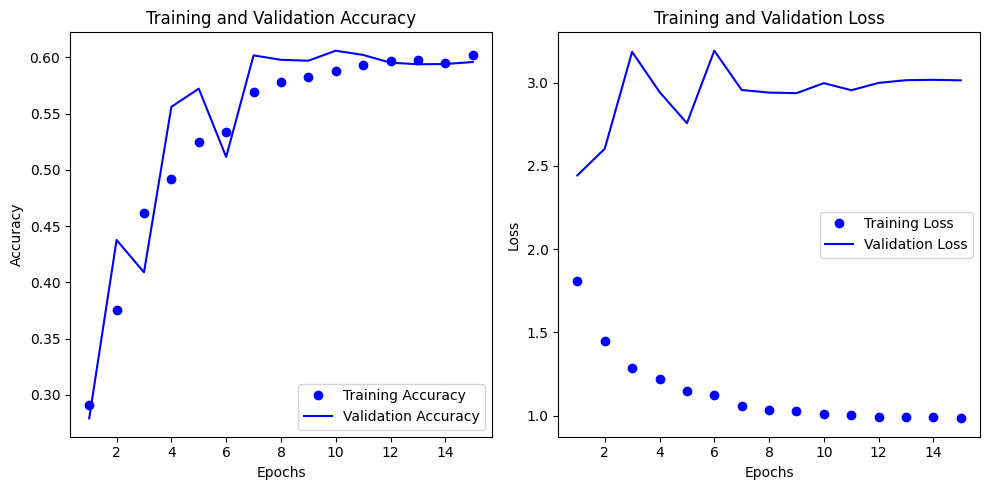

In [9]:
# Plot training history
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
score = HypOptmodel.evaluate(test_faces, test_emotions, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1] * 100)


225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6510 - loss: 1.8423
Test loss: 2.4757862091064453
Test accuracy: 55.22429943084717


I might want to save this model as a pkl or h5 file if it does well enough, so that I dont have to retrain.

V5

225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step


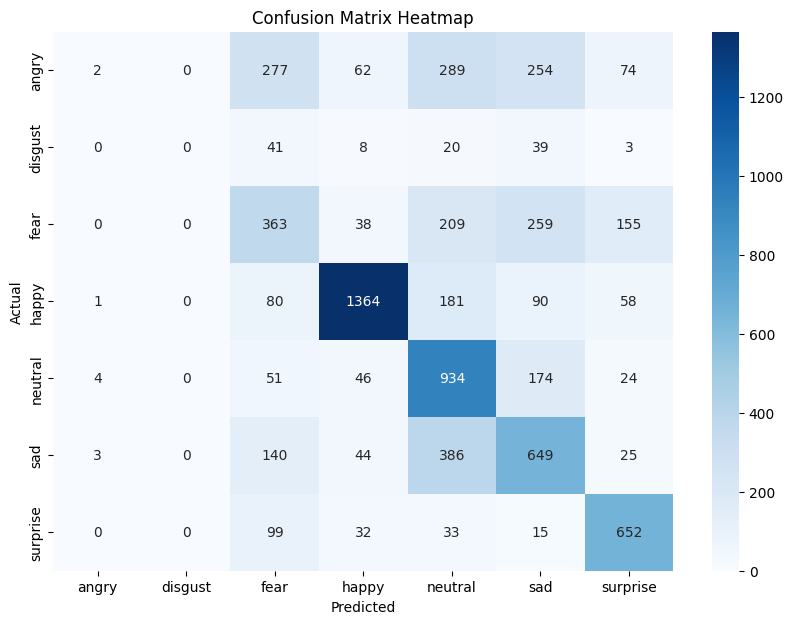

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = HypOptmodel.predict(test_faces)
y_test = test_emotions

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']

# Create heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [12]:
# Attention based model
#For this, I want to try and replicate a different model. Try one that is attention based.
HypOptAttmodel = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4)
])
#Ahh, so create the CNN backbone, then make an attention mechanism

#This is just the placeholder for the data the model will use.
inputs = Input(shape=(48, 48, 1))
HypOptAttmodel_out = HypOptAttmodel(inputs)

seq = layers.Reshape((-1, HypOptAttmodel_out.shape[-1]))(HypOptAttmodel_out)

attn_weights = layers.Dense(1, activation="sigmoid")(seq)       # (batch, seq_len, 1)
attn_weights = layers.Flatten()(attn_weights)                # (batch, seq_len)
attn_weights = layers.Softmax(axis=1)(attn_weights)

#Apply the attention weights to the output of the CNN model
attn_applied = layers.Dot(axes=[1, 1])([attn_weights, seq])

# Define the rest of the model
outputs = tf.keras.layers.Flatten()(attn_applied)
outputs = tf.keras.layers.Dense(units=7, activation="softmax")(outputs)
# Compile the model

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [13]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 6, 6, 192) │  3,620,672 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 36, 192)   │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 36, 1)     │        193 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 36)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 36)        │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 192)       │          0 │ softmax[0][0],    │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 192)       │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │      1,351 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,622,216 (13.82 MB)

 Trainable params: 3,620,040 (13.81 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
#Save after each epoch, and increase model complexity in order to get better performance.
# Also, maybe try multihead attention results?

#The attention model is actually doing worse than the original, oh lordie.
# I am capable, compitent and worthy. I can do this and I will get improvements.



In [20]:
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training the model with a fixed seed
history = model.fit(
    data_generator.flow(train_faces, train_emotions, batch_size=32, seed=SEED),  # Seed added here
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=(val_faces, val_emotions)
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2766 - loss: 1.6695
Epoch 1: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 84s 120ms/step - accuracy: 0.2766 - loss: 1.6693 - val_accuracy: 0.2841 - val_loss: 3.0797 - learning_rate: 0.0010
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3726 - loss: 1.4371
Epoch 2: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - accuracy: 0.3726 - loss: 1.4370 - val_accuracy: 0.4578 - val_loss: 3.3634 - learning_rate: 0.0010
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4661 - loss: 1.2656
Epoch 3: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 76s 119ms/step - accuracy: 0.4661 - loss: 1.2655 - val_accuracy: 0.4363 - val_loss: 3.5429 - learning_rate: 0.0010
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5027 - loss: 1.1915
Epoch 4: val_loss did not improve from 2.44245
634/634 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/

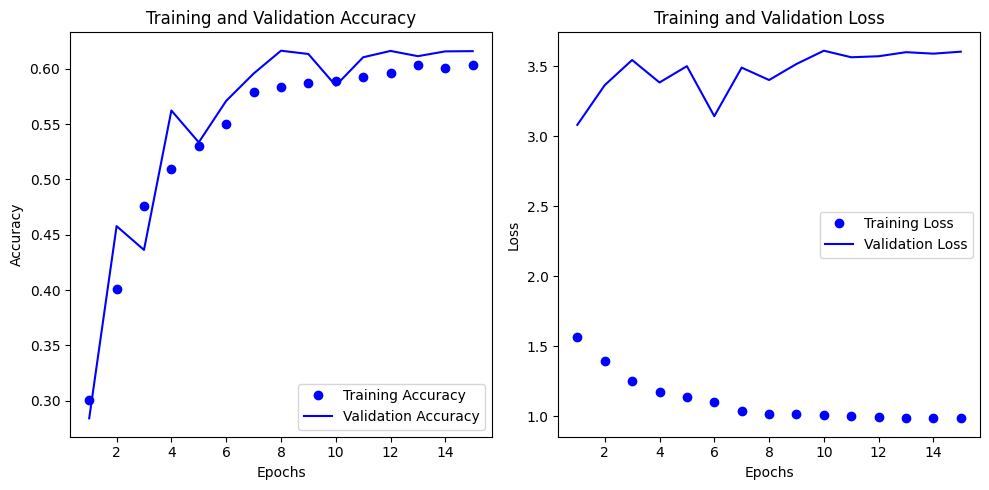

In [21]:
# Plot training history
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Create a heatmap of the results.
#
Best_model = models.load_model('emotion_model.01-3.09.keras')

In [22]:
score = model.evaluate(test_faces, test_emotions, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1] * 100)

225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6459 - loss: 2.1502
Test loss: 2.995061159133911
Test accuracy: 53.427135944366455


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step


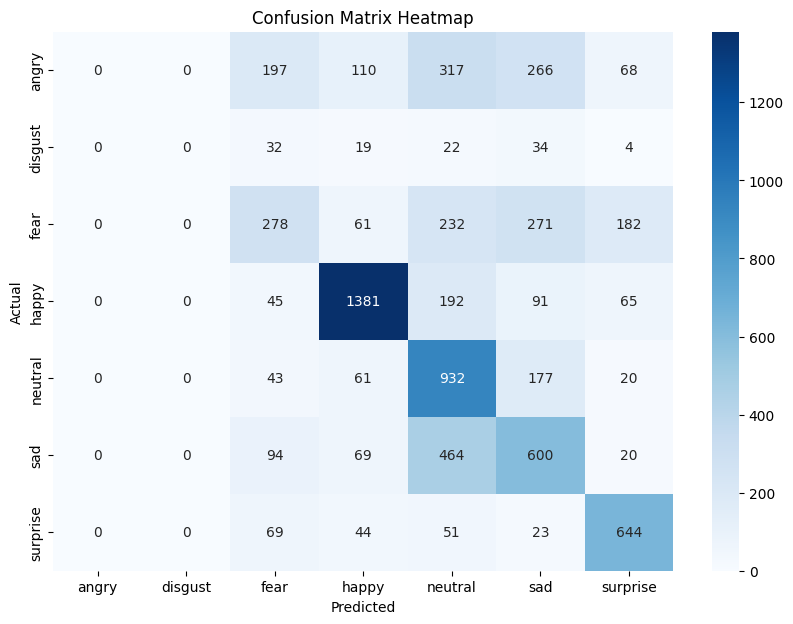

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_faces)
y_test = test_emotions

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']

# Create heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
#Save model to a h5 file.

HypOptmodel.save('HoltAttModel.h5')